In [1]:
import flexs

In [1]:
import editdistance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
import numpy as np
import json

import flexs
from flexs import baselines
import flexs.utils.sequence_utils as s_utils
import torch.nn.functional as F
import torch

In [2]:
exp_name = 'AMP'

# Extend the number of characters by one to include the "Space character" so that we can have a fixed number of sequences...

In [3]:
from collections import OrderedDict

enc_len = 50
num_actions = 21

char_pairs = [('A', 0), ('R', 1), ('N', 2), ('D', 3), ('C', 4), ('E', 5), ('Q', 6), ('G', 7), ('H', 8), ('I', 9), ('L', 10), ('K', 11), ('M', 12), ('F', 13), ('P', 14), ('S', 15), ('T', 16), ('W', 17), ('Y', 18), ('V', 19), ('>', 20)]
mol_enc = OrderedDict(char_pairs)
enc_mol = OrderedDict(list(map(lambda x : (x[1], x[0]), char_pairs)))

In [4]:
def seq_to_enc(seq):
    enc = []
    for i in range(enc_len):
        if i < len(seq):
            enc.append(mol_enc[seq[i]])
            if seq[i] == '>':
                break
        else:
            enc[i].append(20)
    while len(enc) < enc_len:
        enc.append(20)
    
    return F.one_hot(torch.tensor(enc), num_classes=num_actions).numpy()

In [5]:
def convertor(sequences):
    """
        Does the padding of the sequences to the correct length... w/ the extra chars...
        
        Input: sequences List[str]
        
        Return: list[ndarray]
    """
    
    all_seqs = []
    for seq in sequences:
        all_seqs.append(seq_to_enc(seq).flatten())
        
    return np.stack(all_seqs)
    
    
    

In [6]:
import pickle

class AMPLandscape(flexs.Landscape):
    """AMP landscape."""

    def __init__(self, mode):
        """Create a AMP landscape."""
        super().__init__(name="AMP")
        assert mode == 'val' or mode == 'test'
        self.alphabet = flexs
        
        if mode == 'val':
            fname = "data/metarlbo_rfc_not-alibicani.pkl"
        elif mode == 'test':
            fname = "data/metarlbo_rfc_alibicani.pkl"
                
        with open(fname, "rb") as f:
            self.model = pickle.load(f)


    def _fitness_function(self, sequences):
        """
            Takes as input a list of strings (w/ alphabet of 20)
            
            
            Returns numpy array of scores
        """
        
        np_seqs = convertor(sequences)
        
        scores = self.model.predict_proba(np_seqs)[:, 1]
        
        return scores
        
        
        
    

In [7]:
landscape = AMPLandscape("test")
alph_chars = list(mol_enc.keys())[:-1]
alphabet=''.join(alph_chars)

In [8]:
bsize = 250
nRounds = 12

nRuns = 3

In [9]:
explorer_scores = {}

In [10]:
import os

logs_dir = f'./analysis/{exp_name}'

os.listdir(logs_dir)

from datetime import datetime
def get_time():
    return datetime.now().isoformat()

In [11]:
nModelQueries = 4000

# Random Explorer

In [12]:
rand_seq_len = 50


def random_start():
    starting_sequence = "".join([np.random.choice(list(alph_chars)) for _ in range(rand_seq_len)])
    return starting_sequence


starting_sequence = random_start()

In [13]:

scores = []

for _ in range(nRuns):
    starting_sequence = random_start()
    cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                             num_filters=32, hidden_size=100, loss='MSE')

    random_explorer = baselines.explorers.Random(
        cnn,
        rounds=nRounds,
        mu=1,
        starting_sequence=starting_sequence,
        sequences_batch_size=bsize,
        model_queries_per_batch=bsize,
        alphabet=alphabet
    )

    random_sequences, metadata = random_explorer.run(landscape)
    fname = "Random_Explorer_" + get_time() + ".csv"
    random_sequences.to_csv(os.path.join(logs_dir, fname))
    random_sequences

2022-01-25 21:50:37.423134: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


round: 0, top: 0.09, time: 0.000954s
round: 1, top: 0.15, time: 1.302323s
round: 2, top: 0.155, time: 1.278300s
round: 3, top: 0.255, time: 2.626645s
round: 4, top: 0.255, time: 3.854781s
round: 5, top: 0.255, time: 5.205343s
round: 6, top: 0.275, time: 8.741921s
round: 7, top: 0.275, time: 9.588659s
round: 8, top: 0.275, time: 8.421843s
round: 9, top: 0.275, time: 10.686332s
round: 10, top: 0.275, time: 12.122928s
round: 11, top: 0.275, time: 11.537391s
round: 12, top: 0.275, time: 16.070231s
round: 0, top: 0.07, time: 0.000261s
round: 1, top: 0.175, time: 1.305523s
round: 2, top: 0.185, time: 1.908162s
round: 3, top: 0.185, time: 3.105039s
round: 4, top: 0.195, time: 3.496087s
round: 5, top: 0.21, time: 5.812083s
round: 6, top: 0.21, time: 6.229323s
round: 7, top: 0.21, time: 8.026355s
round: 8, top: 0.21, time: 8.355092s
round: 9, top: 0.21, time: 12.991206s
round: 10, top: 0.21, time: 10.910213s
round: 11, top: 0.21, time: 11.787356s
round: 12, top: 0.21, time: 13.006339s
round: 0,

In [56]:
# import json

# with open(os.path.join(logs_dir, "random_baseline_results.json"), "w") as f:
#     json.dump(explorer_scores, f)

# with open(os.path.join(logs_dir, "random_baseline_results.json"), "r") as f:
#     print(json.load(f))

{'random': [[0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29, 0.29], [0.195, 0.22, 0.22, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.26, 0.26, 0.26], [0.24, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275]]}


## Adalead Explorer

In [14]:

scores = []

for _ in range(nRuns):
    starting_sequence = random_start()
    
    cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                             num_filters=32, hidden_size=100, loss='MSE')

    adalead_explorer = baselines.explorers.Adalead(
        cnn,
        rounds=nRounds,
        starting_sequence=starting_sequence,
        sequences_batch_size=bsize,
        model_queries_per_batch=nModelQueries,
        alphabet=alphabet
    )

    adalead_sequences, metadata = adalead_explorer.run(landscape)
    fname = "Adalead_Explorer_" + get_time() + ".csv"
    adalead_sequences.to_csv(os.path.join(logs_dir, fname))
    adalead_sequences


round: 0, top: 0.12, time: 0.000366s
round: 1, top: 0.29, time: 30.772849s
round: 2, top: 0.335, time: 20.630404s
round: 3, top: 0.38, time: 17.457087s
round: 4, top: 0.415, time: 20.114118s
round: 5, top: 0.415, time: 21.160380s
round: 6, top: 0.445, time: 22.111371s
round: 7, top: 0.475, time: 28.329053s
round: 8, top: 0.525, time: 23.123876s
round: 9, top: 0.55, time: 22.367420s
round: 10, top: 0.56, time: 25.857623s
round: 11, top: 0.57, time: 26.235091s
round: 12, top: 0.595, time: 27.901884s
round: 0, top: 0.12, time: 0.001770s
round: 1, top: 0.3, time: 43.705676s
round: 2, top: 0.435, time: 21.779532s
round: 3, top: 0.515, time: 15.717407s
round: 4, top: 0.555, time: 18.693542s
round: 5, top: 0.58, time: 20.157077s
round: 6, top: 0.6, time: 19.794545s
round: 7, top: 0.64, time: 21.196096s
round: 8, top: 0.655, time: 25.210932s
round: 9, top: 0.66, time: 24.349577s
round: 10, top: 0.675, time: 26.081559s
round: 11, top: 0.68, time: 28.519878s
round: 12, top: 0.695, time: 30.10445

In [15]:
# import json

# with open(os.path.join(logs_dir, "adalead_baseline_results.json"), "w") as f:
#     json.dump(explorer_scores, f)

## Genetic Explorer

In [16]:
for _ in range(nRuns):
    cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                             num_filters=32, hidden_size=100, loss='MSE')

    genetic_explorer = baselines.explorers.GeneticAlgorithm(
        cnn,

        population_size=8,
        parent_selection_strategy='wright-fisher', # wright-fisher model decides who gets to 'mate'
        beta=0.01,
        children_proportion=0.2,

        rounds=nRounds,
        starting_sequence=starting_sequence,
        sequences_batch_size=bsize,
        model_queries_per_batch=nModelQueries,
        alphabet=alphabet
    )


    genetic_algo_sequences, metadata = genetic_explorer.run(landscape)
    fname = "Genetic_Explorer_" + get_time() + ".csv"
    genetic_algo_sequences.to_csv(os.path.join(logs_dir, fname))
    genetic_algo_sequences

round: 0, top: 0.235, time: 0.000333s
round: 1, top: 0.285, time: 219.736943s
round: 2, top: 0.405, time: 213.976650s
round: 3, top: 0.435, time: 216.498816s
round: 4, top: 0.475, time: 219.624427s
round: 5, top: 0.505, time: 216.770466s
round: 6, top: 0.51, time: 240.871651s
round: 7, top: 0.55, time: 283.343795s
round: 8, top: 0.56, time: 287.039928s
round: 9, top: 0.56, time: 219.803259s
round: 10, top: 0.57, time: 239.149468s
round: 11, top: 0.605, time: 172.253866s
round: 12, top: 0.63, time: 170.585303s
round: 0, top: 0.235, time: 0.000229s
round: 1, top: 0.255, time: 152.713641s
round: 2, top: 0.255, time: 153.234794s
round: 3, top: 0.255, time: 156.559653s
round: 4, top: 0.26, time: 172.272106s
round: 5, top: 0.275, time: 193.266444s
round: 6, top: 0.295, time: 245.842131s
round: 7, top: 0.335, time: 171.876207s
round: 8, top: 0.395, time: 155.392100s
round: 9, top: 0.42, time: 155.480710s
round: 10, top: 0.445, time: 162.862805s
round: 11, top: 0.455, time: 157.346620s
round: 

## CMAES Explorer

In [17]:

scores = []

for _ in range(nRuns):
    starting_sequence = random_start()

    cnn = baselines.models.CNN(len(starting_sequence), alphabet=alphabet,
                             num_filters=32, hidden_size=100, loss='MSE')

    cmaes_explorer = baselines.explorers.CMAES(
        flexs.LandscapeAsModel(landscape),

        population_size=10,
        max_iter=200,

        rounds=nRounds,
        starting_sequence=starting_sequence,
        sequences_batch_size=bsize,
        model_queries_per_batch=nModelQueries,
        alphabet=alphabet
    )
    
    cmaes_sequences, metadata = cmaes_explorer.run(landscape)
    fname = "CMAES_Explorer_" + get_time() + ".csv"
    cmaes_sequences.to_csv(os.path.join(logs_dir, fname))
    cmaes_sequences
    
    

round: 0, top: 0.1, time: 0.000351s
round: 1, top: 0.23, time: 73.579385s
round: 2, top: 0.28, time: 69.306206s
round: 3, top: 0.355, time: 72.923403s
round: 4, top: 0.415, time: 73.628188s
round: 5, top: 0.43, time: 78.125262s
round: 6, top: 0.44, time: 81.330773s
round: 7, top: 0.44, time: 86.032399s
round: 8, top: 0.44, time: 78.503929s
round: 9, top: 0.455, time: 78.599188s
round: 10, top: 0.455, time: 77.367282s
round: 11, top: 0.455, time: 68.658507s
round: 12, top: 0.455, time: 73.173318s
round: 0, top: 0.12, time: 0.000304s
round: 1, top: 0.265, time: 77.755350s
round: 2, top: 0.265, time: 89.074584s
round: 3, top: 0.34, time: 81.247708s
round: 4, top: 0.38, time: 76.586161s
round: 5, top: 0.41, time: 71.491936s
round: 6, top: 0.41, time: 91.906987s
round: 7, top: 0.41, time: 81.231723s
round: 8, top: 0.41, time: 77.881304s
round: 9, top: 0.455, time: 68.220772s
round: 10, top: 0.455, time: 64.752208s
round: 11, top: 0.465, time: 124.409408s
round: 12, top: 0.525, time: 119.842

In [18]:
# import json

# with open(os.path.join(logs_dir, "cmaes_baseline_results.json"), "w") as f:
#     json.dump(explorer_scores, f)

## DynaPPO Explorer

In [19]:
nModelRounds = nRounds
scores = []

for _ in range(nRuns):
    starting_sequence = random_start()
    dynappo_explorer = baselines.explorers.DynaPPO(  # DynaPPO has its own default ensemble model, so don't use CNN
        landscape=landscape,
        env_batch_size=10,
        num_model_rounds=nModelRounds,
        rounds=nRounds,
        starting_sequence=starting_sequence,
        sequences_batch_size=bsize,
        model_queries_per_batch=nModelQueries,
        alphabet=alphabet,
    )

    dynappo_sequences, metadata = dynappo_explorer.run(landscape)
    fname = "DynaPPO_Explorer_" + get_time() + ".csv"
    dynappo_sequences.to_csv(os.path.join(logs_dir, fname))
    dynappo_sequences

/Users/leofeng/miniconda3/envs/flexsenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(19))
round: 0, top: 0.095, time: 0.000351s
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.
round: 1, top: 0.355, time: 472.579896s
round: 2, top: 0.42, time: 533.425051s


KeyboardInterrupt: 

In [ ]:
# import json

# with open(os.path.join(logs_dir, "dynappo_baseline_results.json"), "w") as f:
#     json.dump(explorer_scores, f)

# Plots some results

In [53]:

results = {
    'adalead': [0.275, 0.38, 0.49, 0.545, 0.61, 0.66, 0.705, 0.73],
    'dyappo': [0.4, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455, 0.455],
    'metarlbo': [0.39, 0.41, 0.45, 0.6, 0.73, 0.75, 0.77, 0.77],
    'random_mut': [0.175, 0.185, 0.185, 0.185, 0.21, 0.28, 0.28, 0.28],
}


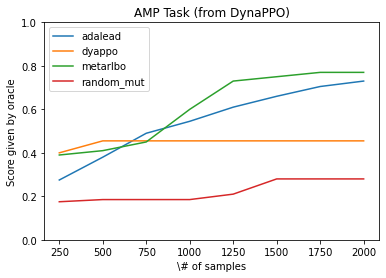

In [57]:
import matplotlib.pyplot as plt

xs = [(i+1)*250 for i in range(8)]


plt.ylim((0, 1))

plt.title("AMP Task (from DynaPPO)")
plt.xlabel("\# of samples")
plt.ylabel("Score given by oracle")


for name, res in results.items():
    plt.plot(xs, res, label=name)
    
plt.legend()